# Project 242

## Import

In [1]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [3]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


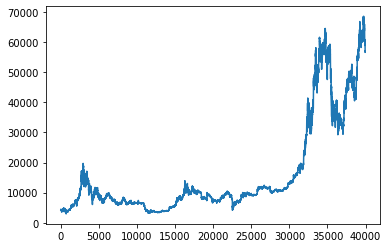

In [4]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [5]:
# Clean data
data = clean_data(data)

Here, we can decide to add features ...

In [6]:
# Add features
#data = add_technical_indicators(data, lookback_period=30)

In [7]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29958, 5) | X_test: (9986, 5)


In [8]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [9]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [10]:
# Add Signal
q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, q_90)
test_data = add_signal(test_data, q_90)

In [11]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (5.0%) | 0 (90.0%) | -1 (5.0%)
Test set: 1 (6.0%) | 0 (88.0%) | -1 (6.0%)


## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [13]:
#X_train, y_train, return_train = prepare_data_for_training(train_data, lookback_period=10)
#X_test, y_test, return_test = prepare_data_for_training(test_data, lookback_period=10)

In [14]:
X_train, y_train = train_data, train_data.Signal
X_test, y_test = test_data, test_data.Signal

### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [15]:
#model = ...

In [16]:
y_pred = baseline(y_test)

### 3. Test prediction model

In [17]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0 #get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = get_WACC(y_test, y_pred, test_data.close)

In [18]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.340276,0,0.339407


### III. Strategy

### 1. Get data ready for backtesting

In [19]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [20]:
signal = y_pred 
close = test_data.close

In [21]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [22]:
strat = Strategy(cash=500, fees=0.001)

In [23]:
strat.run(signal_crop, close_crop, verbose=False)

In [24]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

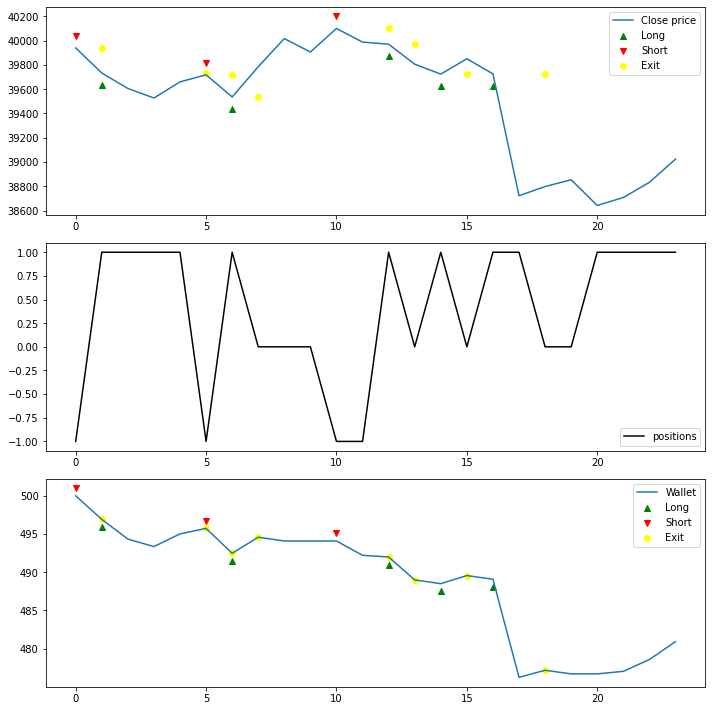

In [25]:
strat.visualize()

### 3. Test performance startegy

In [26]:
SharpeRatio = SharpeRatio(profit)
MaxDrawback = MaxDrawback(profit)
WinLossRatio = WinLossRatio(profit)
CumulativeProfit = CumulativeProfit(profit)
MeanProfit = MeanProfit(profit)

In [27]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[SharpeRatio, MaxDrawback, WinLossRatio, CumulativeProfit, MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,-0.263941,-12.824982,0.666667,-19.074259,-0.76297
